In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import pickle 

# Define Model

In [2]:
class lstm_Classifier(nn.Module):
    def __init__ (self, input_size, hidden_size, num_layers, batch_size, dropout, num_classes):
        super(lstm_Classifier, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.dropout = dropout
        self.num_classes = num_classes

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                            num_layers = num_layers, dropout= dropout)
        self.fc = nn.Linear(hidden_size,num_classes)

    def init_hidden(self,):
        hidden = (torch.randn(self.num_layers, self.batch_size, self.hidden_size),
                  torch.randn(self.num_layers, self.batch_size, self.hidden_size))
        return hidden

    def forward(self, X, hidden = None): 
        
        if hidden == None: 
            hidden = self.init_hidden()

        X,_ = self.lstm(X, hidden)
        X = self.fc(X[-1])

        return X

In [3]:
# difine architecture
input_size = 4
num_layers = 5
hidden_size = 4
batch_size = 128
num_classes = 3
# input = [Open, HIgh, low, Close] output = [Up, Neutral, Down]
model = lstm_Classifier(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers,
                        batch_size=batch_size, dropout= .05, num_classes=num_classes)

# Prepare Data

In [4]:
# each row holds the time series (list) open, high, low, close of a stock over a single day
# each list has 17 elements 
#  0 - 5 : pre
#  6 -12 : market
#  13 - 16: post
# we attemp to use the pre data to predict the change in market open and close
features = 4 # input = [Open, HIgh, low, Close] 
sequence_len = 6

# load data
data = pd.read_pickle('Data/NASDEQ_data.pkl')

# remove bad data
data = data[data['Close'].map(len) > 12]

# calculate change 
data['Change'] = data.apply(lambda x: (x['Close'][12] - x['Open'][6])/x['Open'][6], axis = 1)

# define labels
# data['Label'] = pd.qcut(data['Change'],q=3,labels=[0,1,2])
# pd.qcut(data['Change'],q=3).value_counts() #view ranges
data['Label'] = pd.cut(data['Change'],bins=[-10,-.01,.01,10],labels=[0,1,2])
data['Label'].value_counts()

1    8271
0    3414
2    3388
Name: Label, dtype: int64

In [5]:
# isolate pre market data
cols = ['Open', 'High', 'Low', 'Close'] 
pre = pd.DataFrame()
for col in cols:
    pre[col] = data.apply(lambda x: x[col][0:6],axis = 1)

# create input array
X = np.array(list(pre.apply(lambda x: [x['Open'],x['High'],x['Low'],x['Close']],axis = 1)))
X = np.reshape(X, (-1,sequence_len,features))

# create output array
y = list(data['Label'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# create data loaders
train_data = TensorDataset(torch.from_numpy(X_train).double(),torch.tensor(y_train))
test_data = TensorDataset(torch.from_numpy(X_test).double(),torch.tensor(y_test))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Train

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = model.to(device)
optimizer = Adam(model.parameters(),lr=1e-5)
loss_func = nn.CrossEntropyLoss(weight=None)

In [7]:
train_losses = []
test_losses = []

In [8]:
epoches = 500
validate_per = 100
for epoch in range(epoches):

    # train
    model.train()
    for batch, labels in train_loader:
 
        if batch.shape[0] != batch_size: continue #skip incomplete batch
        
        hidden = (torch.randn(num_layers, batch_size, hidden_size).to(device),
                  torch.randn(num_layers, batch_size, hidden_size).to(device))
        batch = batch.to(device)
        labels = labels.to(device)

        model.zero_grad()
        out = model(batch.view(sequence_len, batch_size, input_size).float(),hidden)
        batch_loss = loss_func(out, labels.long())
        train_losses.append(batch_loss.item())
        batch_loss.backward()
        optimizer.step()
    
    # validate
    if epoch % validate_per == 0:
        model.eval()
        val_loss = 0
        for batch, labels in test_loader:

            if batch.shape[0] != batch_size: continue #skip incomplete batch

            hidden = (torch.randn(num_layers, batch_size, hidden_size).to(device),
                    torch.randn(num_layers, batch_size, hidden_size).to(device))
            batch = batch.to(device)
            labels = labels.to(device)

            out = model(batch.view(sequence_len, batch_size, input_size).float(), hidden)
            batch_loss = loss_func(out, labels.long())
            val_loss += batch_loss.item()
            
        val_loss /= len(test_loader)
        print('Epoch:', epoch, 'Val loss:', val_loss)
        test_losses.append(val_loss)

Epoch: 0 Val loss: 0.9915390491485596
Epoch: 100 Val loss: 0.9668779989083608
Epoch: 200 Val loss: 0.9649573604265849
Epoch: 300 Val loss: 0.9676133294900259
Epoch: 400 Val loss: 0.9660908063252767


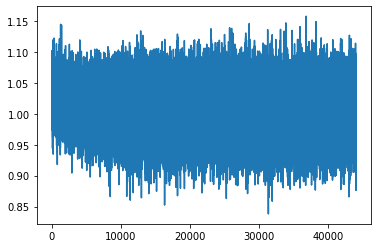

In [10]:
plt.plot(train_losses)
plt.show()